In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchlens

# Device configuration
# I am using a Mac M3 chip, so I can't use CUDA, but if you are on nvidia, change this to CUDA
device = torch.device("mps")

In [34]:
num_epochs = 1000
batch_size = 1024
learning_rate = 0.004

In [35]:
train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# get mean and std of the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=False)
data = next(iter(train_loader))
mean = data[0].mean()
std = data[0].std()

(mean, std)

(tensor(0.1918), tensor(0.3483))

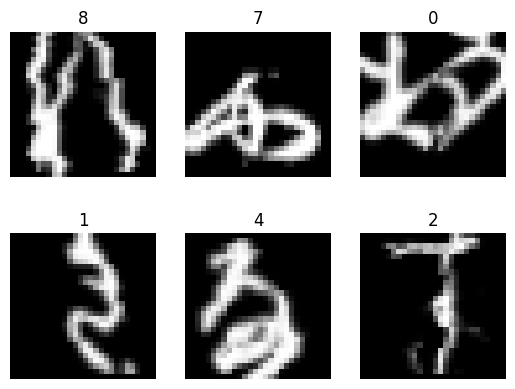

In [36]:
# KMNIST dataset
transform_train = transforms.Compose([
        transforms.RandomRotation(10),  # Rotation
        transforms.RandomAffine(0, shear=10),  # Shearing
        transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Shifting up and down
        transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Zooming
        transforms.Resize((28, 28)),  # Rescale
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# visualize some of the data
examples = iter(train_loader)
example_data, example_targets = next(examples)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.title(example_targets[i].item())
    plt.axis('off')
    plt.imshow(example_data[i][0], cmap='gray')

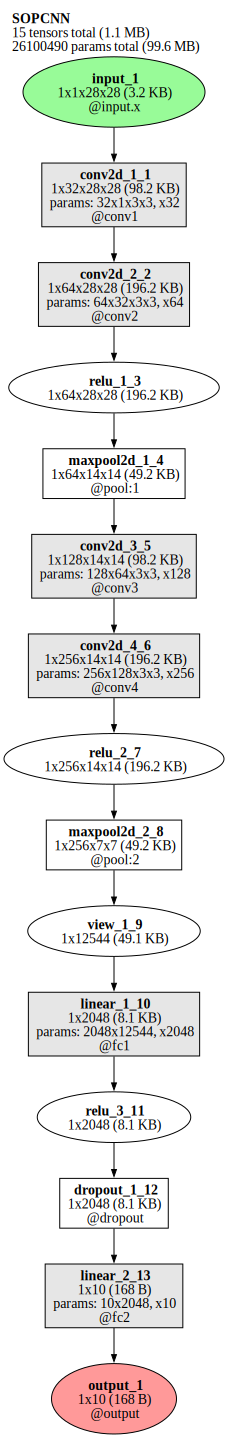

In [67]:
class SOPCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SOPCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 7 * 7, 2048)
        self.fc2 = nn.Linear(2048, num_classes)
        self.dropout = nn.Dropout(0.8)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 256 * 7 * 7)  # Flatten the tensor
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = SOPCNN().to(device)
x = torch.randn(1, 1, 28, 28).to(device)
y = model(x)

model_history = torchlens.log_forward_pass(model, x, layers_to_save='all', vis_opt='unrolled', vis_fileformat='png', vis_outpath='graphs/SOPCNN.png', vis_direction='topdown')

In [20]:
# early_stopping.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [45]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=learning_rate, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=10, verbose=True, path='sop_checkpoint.pt')

train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []
    
# Training loop
for epoch in range(num_epochs):
    
    # Train the model
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #capture loss
        train_losses.append(loss.item())

    # Validate the model
    model.eval()
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            output = model(test_images)
            loss = criterion(output, test_labels)
            valid_losses.append(loss.item())
    
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    # print training/validation statistics
    epoch_len = len(str(num_epochs))
        
    print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)
    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping!")
        break

    scheduler.step()

100%|██████████| 59/59 [00:18<00:00,  3.27it/s]


[   0/1000] train_loss: 0.05326 valid_loss: 0.12122
Validation loss decreased (inf --> 0.121223).  Saving model ...


100%|██████████| 59/59 [00:17<00:00,  3.31it/s]


[   1/1000] train_loss: 0.06408 valid_loss: 0.09926
Validation loss decreased (0.121223 --> 0.099260).  Saving model ...


100%|██████████| 59/59 [00:17<00:00,  3.28it/s]


[   2/1000] train_loss: 0.07253 valid_loss: 0.09547
Validation loss decreased (0.099260 --> 0.095466).  Saving model ...


100%|██████████| 59/59 [00:18<00:00,  3.27it/s]


[   3/1000] train_loss: 0.07486 valid_loss: 0.09413
Validation loss decreased (0.095466 --> 0.094127).  Saving model ...


100%|██████████| 59/59 [00:17<00:00,  3.29it/s]


[   4/1000] train_loss: 0.07266 valid_loss: 0.09689
EarlyStopping counter: 1 out of 10


100%|██████████| 59/59 [00:17<00:00,  3.29it/s]


[   5/1000] train_loss: 0.07110 valid_loss: 0.08649
Validation loss decreased (0.094127 --> 0.086491).  Saving model ...


100%|██████████| 59/59 [00:18<00:00,  3.25it/s]


[   6/1000] train_loss: 0.06555 valid_loss: 0.09776
EarlyStopping counter: 1 out of 10


100%|██████████| 59/59 [00:17<00:00,  3.29it/s]


[   7/1000] train_loss: 0.06200 valid_loss: 0.09276
EarlyStopping counter: 2 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.27it/s]


[   8/1000] train_loss: 0.06023 valid_loss: 0.09037
EarlyStopping counter: 3 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.26it/s]


[   9/1000] train_loss: 0.05956 valid_loss: 0.08414
Validation loss decreased (0.086491 --> 0.084139).  Saving model ...


100%|██████████| 59/59 [00:18<00:00,  3.26it/s]


[  10/1000] train_loss: 0.05611 valid_loss: 0.08821
EarlyStopping counter: 1 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.25it/s]


[  11/1000] train_loss: 0.05060 valid_loss: 0.08758
EarlyStopping counter: 2 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.26it/s]


[  12/1000] train_loss: 0.04755 valid_loss: 0.09117
EarlyStopping counter: 3 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.22it/s]


[  13/1000] train_loss: 0.04608 valid_loss: 0.08454
EarlyStopping counter: 4 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.26it/s]


[  14/1000] train_loss: 0.04433 valid_loss: 0.08126
Validation loss decreased (0.084139 --> 0.081264).  Saving model ...


100%|██████████| 59/59 [00:18<00:00,  3.26it/s]


[  15/1000] train_loss: 0.04480 valid_loss: 0.09661
EarlyStopping counter: 1 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.27it/s]


[  16/1000] train_loss: 0.04412 valid_loss: 0.07751
Validation loss decreased (0.081264 --> 0.077510).  Saving model ...


100%|██████████| 59/59 [00:18<00:00,  3.18it/s]


[  17/1000] train_loss: 0.03999 valid_loss: 0.08244
EarlyStopping counter: 1 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.23it/s]


[  18/1000] train_loss: 0.03923 valid_loss: 0.08041
EarlyStopping counter: 2 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.21it/s]


[  19/1000] train_loss: 0.03519 valid_loss: 0.08145
EarlyStopping counter: 3 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.22it/s]


[  20/1000] train_loss: 0.03533 valid_loss: 0.07733
Validation loss decreased (0.077510 --> 0.077330).  Saving model ...


100%|██████████| 59/59 [00:18<00:00,  3.23it/s]


[  21/1000] train_loss: 0.03240 valid_loss: 0.08631
EarlyStopping counter: 1 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.19it/s]


[  22/1000] train_loss: 0.03387 valid_loss: 0.08528
EarlyStopping counter: 2 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.24it/s]


[  23/1000] train_loss: 0.02889 valid_loss: 0.08599
EarlyStopping counter: 3 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.26it/s]


[  24/1000] train_loss: 0.03069 valid_loss: 0.08273
EarlyStopping counter: 4 out of 10


100%|██████████| 59/59 [00:17<00:00,  3.31it/s]


[  25/1000] train_loss: 0.03190 valid_loss: 0.08584
EarlyStopping counter: 5 out of 10


100%|██████████| 59/59 [00:17<00:00,  3.31it/s]


[  26/1000] train_loss: 0.02939 valid_loss: 0.08244
EarlyStopping counter: 6 out of 10


100%|██████████| 59/59 [00:17<00:00,  3.29it/s]


[  27/1000] train_loss: 0.02743 valid_loss: 0.07642
Validation loss decreased (0.077330 --> 0.076418).  Saving model ...


100%|██████████| 59/59 [00:18<00:00,  3.18it/s]


[  28/1000] train_loss: 0.02730 valid_loss: 0.08064
EarlyStopping counter: 1 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.26it/s]


[  29/1000] train_loss: 0.02548 valid_loss: 0.07819
EarlyStopping counter: 2 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.26it/s]


[  30/1000] train_loss: 0.02608 valid_loss: 0.07992
EarlyStopping counter: 3 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.28it/s]


[  31/1000] train_loss: 0.02521 valid_loss: 0.08061
EarlyStopping counter: 4 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.27it/s]


[  32/1000] train_loss: 0.02460 valid_loss: 0.08520
EarlyStopping counter: 5 out of 10


100%|██████████| 59/59 [00:17<00:00,  3.31it/s]


[  33/1000] train_loss: 0.02374 valid_loss: 0.08112
EarlyStopping counter: 6 out of 10


100%|██████████| 59/59 [00:17<00:00,  3.32it/s]


[  34/1000] train_loss: 0.02392 valid_loss: 0.08612
EarlyStopping counter: 7 out of 10


100%|██████████| 59/59 [00:17<00:00,  3.29it/s]


[  35/1000] train_loss: 0.02194 valid_loss: 0.08388
EarlyStopping counter: 8 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.23it/s]


[  36/1000] train_loss: 0.02333 valid_loss: 0.08036
EarlyStopping counter: 9 out of 10


100%|██████████| 59/59 [00:18<00:00,  3.21it/s]


[  37/1000] train_loss: 0.02258 valid_loss: 0.08392
EarlyStopping counter: 10 out of 10
Early stopping!


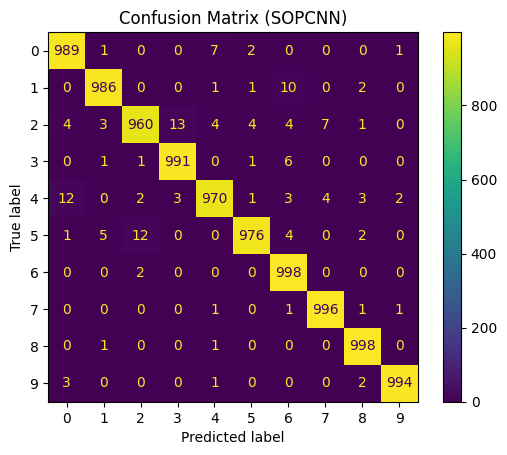

Model Architecture:
SOPCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)

Model Evaluation:
Accuracy: 0.9858

Hyperparameters:
Learning Rate: 0.004
Batch Size: 1024
Number of Epochs: 1000


In [65]:
# Evaluation and confusion matrix
model.load_state_dict(torch.load('sop_checkpoint.pt', weights_only=True))

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
cm_display.plot()
plt.title("Confusion Matrix (SOPCNN)")
plt.show()

# Model summary of accuracy and hyperparameters
print("Model Architecture:")
print(model)
print("\nModel Evaluation:")
print(f"Accuracy: {np.mean(np.array(y_true) == np.array(y_pred))}")
print("\nHyperparameters:")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")


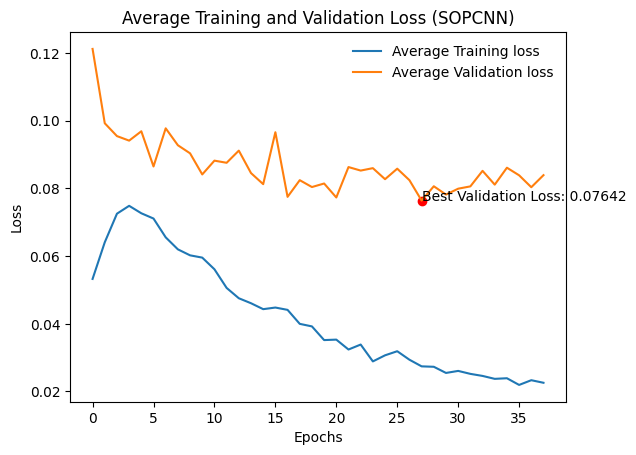

In [68]:
# accuracy overtime plot
plt.plot(avg_train_losses, label='Average Training loss')
plt.plot(avg_valid_losses, label='Average Validation loss')
plt.title('Average Training and Validation Loss (SOPCNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

# plot the point of best accuracy
best_val_loss_epoch = np.argmin(avg_valid_losses)
plt.scatter(best_val_loss_epoch, early_stopping.best_val_loss, color='red')
plt.text(best_val_loss_epoch, early_stopping.best_val_loss, f'Best Validation Loss: {early_stopping.best_val_loss:.5f}')

plt.show()